## Flight Delay Prediction (Binary Classification)

In [ ]:
import sys
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install scikit-learn
# !{sys.executable} -m pip install ydata-profiling

### Preparation

In [2]:
# Data Handeling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
import inspect
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Options
%matplotlib inline
pd.set_option('display.max_columns', None)
sns.set_theme()
pd.set_option('display.float_format', '{:.2f}'.format)

# Initializing Result DataFrame
result_df = pd.DataFrame(columns=['Model', 'Model Type', 'Train Score', 'Test Score', 'Settings'])

### Importing Dataset

Making the new dataset

In [9]:
df = pd.read_pickle('./Datasets/flight_dataset.pkl')

In [48]:
df.drop(['DAY_OF_MONTH', 'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY_NEW', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY_NEW', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'DISTANCE', 'LATITUDE', 'LONGITUDE', 'CARRIER_DELAY', 'SECURITY_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'LATE_AIRCRAFT_DELAY', 'SEGMENT_NUMBER'], axis=1, inplace=True)

In [16]:
df.to_pickle('./Datasets/flight_dataset_ml.pkl')

Creating a stratified sample

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit

stratified_split = StratifiedShuffleSplit(n_splits=1, train_size=100000, random_state=90)

# Generate the indices for the stratified sample
indices = next(stratified_split.split(df, df['DEP_DEL15']))

# Extract the stratified sample from the DataFrame
stratified_sample = df.loc[indices[0]]

In [11]:
df.shape

(6489062, 44)

In [50]:
stratified_sample['DEP_DEL15'].value_counts()

DEP_DEL15
0    81086
1    18914
Name: count, dtype: int64

In [51]:
stratified_sample.to_pickle('./Datasets/flight_dataset_sample_small.pkl')

Future importing of full dataset and sample

In [12]:
# df = pd.read_pickle('./Datasets/flight_dataset_ml.pkl')
# df_sample = pd.read_pickle('./Datasets/flight_dataset_sample.pkl')
df_sample = pd.read_pickle('./Datasets/flight_dataset_sample_small.pkl')
#df = pd.read_pickle('./Datasets/flight_dataset.pkl')

In [13]:
df_sample.shape

(100000, 26)

Generate ydata report

In [ ]:
from ydata_profiling import ProfileReport

report = ProfileReport(stratified_sample, title="Flight Report (Sample)")

report.to_file('report.html')

### Exploring Data

In [32]:
df.head()

,MONTH,DAY_OF_WEEK,TAIL_NUM,DEST_AIRPORT_ID,DEP_DEL15,DEP_TIME_BLK,ARR_TIME_BLK,DISTANCE_GROUP,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,CARRIER_NAME,AIRPORT_FLIGHTS_MONTH,AIRLINE_FLIGHTS_MONTH,AIRLINE_AIRPORT_FLIGHTS_MONTH,AVG_MONTHLY_PASS_AIRPORT,AVG_MONTHLY_PASS_AIRLINE,FLT_ATTENDANTS_PER_PASS,GROUND_SERV_PER_PASS,PLANE_AGE,DEPARTING_AIRPORT,PREVIOUS_AIRPORT,PRCP,SNOW,SNWD,TMAX,AWND
0,1,7,N958WN,14679,0,0800-0859,0900-0959,2,25,143,Southwest Airlines Co.,13056,107363,5873,1903352,13382999,0.00,0.00,8,McCarran International,NONE,0.00,0.00,0.00,65.00,2.91
1,1,7,N309DN,10397,0,0700-0759,1400-1459,7,29,191,Delta Air Lines Inc.,13056,73508,1174,1903352,12460183,0.00,0.00,3,McCarran International,NONE,0.00,0.00,0.00,65.00,2.91
2,1,7,N67171,10397,0,0600-0659,1200-1259,7,27,199,Delta Air Lines Inc.,13056,73508,1174,1903352,12460183,0.00,0.00,18,McCarran International,NONE,0.00,0.00,0.00,65.00,2.91
3,1,7,N884DN,12478,0,0600-0659,1300-1359,9,27,180,Delta Air Lines Inc.,13056,73508,1174,1903352,12460183,0.00,0.00,2,McCarran International,NONE,0.00,0.00,0.00,65.00,2.91
4,1,7,N910NK,13930,0,0001-0559,0600-0659,7,10,182,Spirit Air Lines,13056,15023,1257,1903352,2688839,0.00,0.00,1,McCarran International,NONE,0.00,0.00,0.00,65.00,2.91


In [40]:
df.columns

Index(['MONTH', 'DAY_OF_WEEK', 'TAIL_NUM', 'DEST_AIRPORT_ID', 'DEP_DEL15',
       'DEP_TIME_BLK', 'ARR_TIME_BLK', 'DISTANCE_GROUP', 'CONCURRENT_FLIGHTS',
       'NUMBER_OF_SEATS', 'CARRIER_NAME', 'AIRPORT_FLIGHTS_MONTH',
       'AIRLINE_FLIGHTS_MONTH', 'AIRLINE_AIRPORT_FLIGHTS_MONTH',
       'AVG_MONTHLY_PASS_AIRPORT', 'AVG_MONTHLY_PASS_AIRLINE',
       'FLT_ATTENDANTS_PER_PASS', 'GROUND_SERV_PER_PASS', 'PLANE_AGE',
       'DEPARTING_AIRPORT', 'PREVIOUS_AIRPORT', 'PRCP', 'SNOW', 'SNWD', 'TMAX',
       'AWND'],
      dtype='object')

### General Info about Data

In [41]:
# Shape of the dataset
print(f'The dataset contains {df.shape[1]} columns and {df.shape[0]:,.0f} rows.')

The dataset contains 26 columns and 6,489,062 rows.


In [42]:
# Target Value - Spread
df['DEP_DEL15'].value_counts()

0    5261694
1    1227368
Name: DEP_DEL15, dtype: int64

In [43]:
# Standard Statistical Measures
df.describe()

,DEST_AIRPORT_ID,DEP_DEL15,DISTANCE_GROUP,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,AIRPORT_FLIGHTS_MONTH,AIRLINE_FLIGHTS_MONTH,AIRLINE_AIRPORT_FLIGHTS_MONTH,AVG_MONTHLY_PASS_AIRPORT,AVG_MONTHLY_PASS_AIRLINE,FLT_ATTENDANTS_PER_PASS,GROUND_SERV_PER_PASS,PLANE_AGE,PRCP,SNOW,SNWD,TMAX,AWND
count,6489062.00,6489062.00,6489062.00,6489062.00,6489062.00,6489062.00,6489062.00,6489062.00,6489062.00,6489062.00,6489062.00,6489062.00,6489062.00,6489062.00,6489062.00,6489062.00,6489062.00,6489062.00
mean,12695.74,0.19,3.82,27.84,133.74,12684.58,62960.58,3459.25,1588638.53,7814970.00,0.00,0.00,11.53,0.10,0.03,0.09,71.47,8.34
std,1523.01,0.39,2.38,21.51,46.45,8839.80,34382.23,4251.14,1123847.25,5046881.55,0.00,0.00,6.94,0.34,0.32,0.73,18.35,3.61
min,10135.00,0.00,1.00,1.00,44.00,1100.00,5582.00,1.00,70476.00,473794.00,0.00,0.00,0.00,0.00,0.00,0.00,-10.00,0.00
25%,11292.00,0.00,2.00,11.00,90.00,5345.00,25034.00,654.00,673221.00,2688839.00,0.00,0.00,5.00,0.00,0.00,0.00,59.00,5.82
50%,12889.00,0.00,3.00,23.00,143.00,11562.00,70878.00,2251.00,1486066.00,8501631.00,0.00,0.00,12.00,0.00,0.00,0.00,74.00,7.83
75%,14057.00,0.00,5.00,39.00,172.00,17615.00,86312.00,4806.00,2006675.00,12460183.00,0.00,0.00,17.00,0.02,0.00,0.00,86.00,10.29
max,16869.00,1.00,11.00,109.00,337.00,35256.00,117728.00,21837.00,4365661.00,13382999.00,0.00,0.00,32.00,11.63,17.20,25.20,115.00,33.78


In [44]:
# NaN Values
df.isna().sum()

MONTH                            0
DAY_OF_WEEK                      0
TAIL_NUM                         0
DEST_AIRPORT_ID                  0
DEP_DEL15                        0
DEP_TIME_BLK                     0
ARR_TIME_BLK                     0
DISTANCE_GROUP                   0
CONCURRENT_FLIGHTS               0
NUMBER_OF_SEATS                  0
CARRIER_NAME                     0
AIRPORT_FLIGHTS_MONTH            0
AIRLINE_FLIGHTS_MONTH            0
AIRLINE_AIRPORT_FLIGHTS_MONTH    0
AVG_MONTHLY_PASS_AIRPORT         0
AVG_MONTHLY_PASS_AIRLINE         0
FLT_ATTENDANTS_PER_PASS          0
GROUND_SERV_PER_PASS             0
PLANE_AGE                        0
DEPARTING_AIRPORT                0
PREVIOUS_AIRPORT                 0
PRCP                             0
SNOW                             0
SNWD                             0
TMAX                             0
AWND                             0
dtype: int64

In [46]:
# Data Types
df.dtypes

MONTH                             object
DAY_OF_WEEK                       object
TAIL_NUM                          object
DEST_AIRPORT_ID                    int64
DEP_DEL15                           int8
DEP_TIME_BLK                      object
ARR_TIME_BLK                      object
DISTANCE_GROUP                      int8
CONCURRENT_FLIGHTS                 int64
NUMBER_OF_SEATS                    int16
CARRIER_NAME                      object
AIRPORT_FLIGHTS_MONTH              int64
AIRLINE_FLIGHTS_MONTH              int64
AIRLINE_AIRPORT_FLIGHTS_MONTH      int64
AVG_MONTHLY_PASS_AIRPORT           int64
AVG_MONTHLY_PASS_AIRLINE           int64
FLT_ATTENDANTS_PER_PASS          float64
GROUND_SERV_PER_PASS             float64
PLANE_AGE                          int32
DEPARTING_AIRPORT                 object
PREVIOUS_AIRPORT                  object
PRCP                             float64
SNOW                             float64
SNWD                             float64
TMAX            

In [49]:
df_sample.dtypes

MONTH                              int64
DAY_OF_WEEK                        int64
TAIL_NUM                          object
DEST_AIRPORT_ID                    int64
DEP_DEL15                          int64
DEP_TIME_BLK                      object
ARR_TIME_BLK                      object
DISTANCE_GROUP                     int64
CONCURRENT_FLIGHTS                 int64
NUMBER_OF_SEATS                    int64
CARRIER_NAME                      object
AIRPORT_FLIGHTS_MONTH              int64
AIRLINE_FLIGHTS_MONTH              int64
AIRLINE_AIRPORT_FLIGHTS_MONTH      int64
AVG_MONTHLY_PASS_AIRPORT           int64
AVG_MONTHLY_PASS_AIRLINE           int64
FLT_ATTENDANTS_PER_PASS          float64
GROUND_SERV_PER_PASS             float64
PLANE_AGE                          int64
DEPARTING_AIRPORT                 object
PREVIOUS_AIRPORT                  object
PRCP                             float64
SNOW                             float64
SNWD                             float64
TMAX            

In [50]:
df_sample.head()

,MONTH,DAY_OF_WEEK,TAIL_NUM,DEST_AIRPORT_ID,DEP_DEL15,DEP_TIME_BLK,ARR_TIME_BLK,DISTANCE_GROUP,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,CARRIER_NAME,AIRPORT_FLIGHTS_MONTH,AIRLINE_FLIGHTS_MONTH,AIRLINE_AIRPORT_FLIGHTS_MONTH,AVG_MONTHLY_PASS_AIRPORT,AVG_MONTHLY_PASS_AIRLINE,FLT_ATTENDANTS_PER_PASS,GROUND_SERV_PER_PASS,PLANE_AGE,DEPARTING_AIRPORT,PREVIOUS_AIRPORT,PRCP,SNOW,SNWD,TMAX,AWND
2504636,5,3,N754SW,13796,0,0600-0659,0800-0859,3,27,143,Southwest Airlines Co.,12037,113709,924,1960746,13382999,0.00,0.00,20,Seattle International,NONE,0.00,0.00,0.00,75.00,7.61
4879868,10,7,N659BR,11267,0,2000-2059,2100-2159,1,65,50,SkyWest Airlines Inc.,14057,71625,4229,1486066,3472966,0.00,0.00,18,Detroit Metro Wayne County,State College Air Depot,0.00,0.00,0.00,69.00,1.79
5017284,10,2,N61887,12266,0,2100-2159,2300-2359,4,41,173,United Air Lines Inc.,29960,54923,7167,3103410,8501631,0.00,0.00,4,Chicago O'Hare International,Miami International,0.00,0.00,0.00,62.00,10.51
2371711,5,2,N53442,12953,1,1900-1959,2300-2359,6,23,173,United Air Lines Inc.,14978,53980,5205,1690031,8501631,0.00,0.00,10,Houston Intercontinental,San Francisco International,0.00,0.00,0.00,83.00,6.71
4663982,9,4,N918DU,13487,0,0800-0859,1000-1059,5,4,180,Delta Air Lines Inc.,2185,81338,422,270922,12460183,0.00,0.00,0,Bradley International,NONE,0.00,0.00,0.00,73.00,4.70


### Visualizations

In [5]:
# Getting only numeric columns from DF
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_df = df_sample.select_dtypes(include=numerics)

In [6]:
# Calculating Correlations
corr_df = numeric_df.corr()

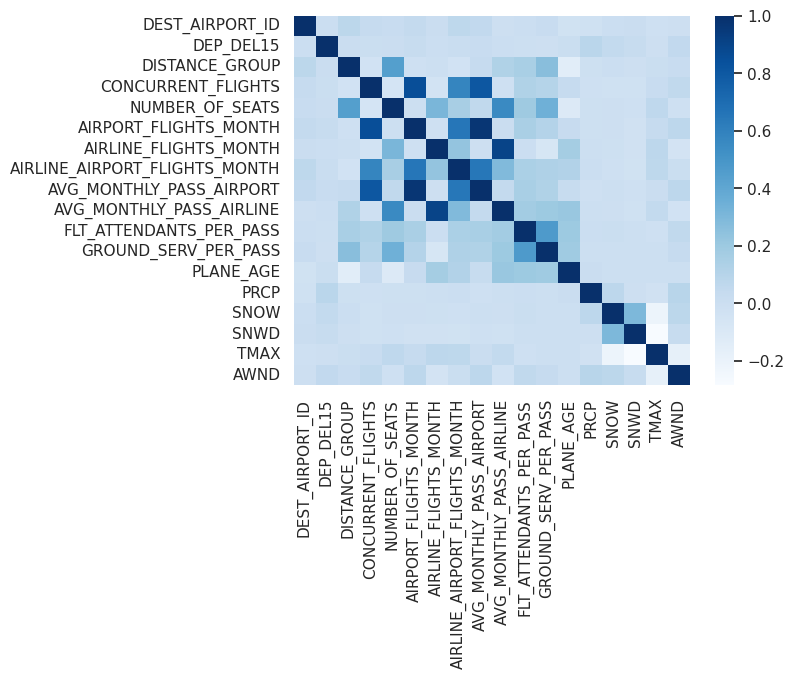

In [8]:
sns.heatmap(corr_df, cmap='Blues')
plt.savefig('correlation.png', bbox_inches='tight')


In [37]:
corr_df.loc['DEP_DEL15']

MONTH                           -0.02
DAY_OF_WEEK                     -0.00
DEST_AIRPORT_ID                  0.01
DEP_DEL15                        1.00
DISTANCE_GROUP                   0.01
CONCURRENT_FLIGHTS               0.01
NUMBER_OF_SEATS                  0.01
AIRPORT_FLIGHTS_MONTH            0.03
AIRLINE_FLIGHTS_MONTH            0.00
AIRLINE_AIRPORT_FLIGHTS_MONTH    0.01
AVG_MONTHLY_PASS_AIRPORT         0.02
AVG_MONTHLY_PASS_AIRLINE         0.00
FLT_ATTENDANTS_PER_PASS         -0.00
GROUND_SERV_PER_PASS            -0.02
PLANE_AGE                        0.01
PRCP                             0.08
SNOW                             0.05
SNWD                             0.03
TMAX                            -0.01
AWND                             0.05
Name: DEP_DEL15, dtype: float64

In [ ]:
sns.pairplot(numeric_df, hue="DEP_DEL15", diag_kind="hist")

### Machine Learning

In [13]:
# df_sample_enc = pd.get_dummies(df_sample, columns=['DEP_TIME_BLK', 'ARR_TIME_BLK'])

df_sample_enc = pd.get_dummies(df_sample, columns=['DEP_TIME_BLK', 'ARR_TIME_BLK', 'TAIL_NUM', 'DEPARTING_AIRPORT', 'CARRIER_NAME', 'PREVIOUS_AIRPORT'])


In [14]:
df_sample_enc.shape

(100000, 6154)

In [6]:
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder()

selected_columns = ['TAIL_NUM', 'DEPARTING_AIRPORT', 'CARRIER_NAME', 'PREVIOUS_AIRPORT']

selected_df = df_sample_enc[selected_columns].copy()

encoded_data = enc.fit_transform(selected_df)

df_sample_enc[selected_columns] = encoded_data


In [15]:
X = df_sample_enc.drop('DEP_DEL15', axis=1)
y = df_sample_enc['DEP_DEL15']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=68, stratify=y)

In [56]:
df_sample_enc.head()

,MONTH,DAY_OF_WEEK,TAIL_NUM,DEST_AIRPORT_ID,DEP_DEL15,DISTANCE_GROUP,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,CARRIER_NAME,AIRPORT_FLIGHTS_MONTH,AIRLINE_FLIGHTS_MONTH,AIRLINE_AIRPORT_FLIGHTS_MONTH,AVG_MONTHLY_PASS_AIRPORT,AVG_MONTHLY_PASS_AIRLINE,FLT_ATTENDANTS_PER_PASS,GROUND_SERV_PER_PASS,PLANE_AGE,DEPARTING_AIRPORT,PREVIOUS_AIRPORT,PRCP,SNOW,SNWD,TMAX,AWND,DEP_TIME_BLK_0001-0559,DEP_TIME_BLK_0600-0659,DEP_TIME_BLK_0700-0759,DEP_TIME_BLK_0800-0859,DEP_TIME_BLK_0900-0959,DEP_TIME_BLK_1000-1059,DEP_TIME_BLK_1100-1159,DEP_TIME_BLK_1200-1259,DEP_TIME_BLK_1300-1359,DEP_TIME_BLK_1400-1459,DEP_TIME_BLK_1500-1559,DEP_TIME_BLK_1600-1659,DEP_TIME_BLK_1700-1759,DEP_TIME_BLK_1800-1859,DEP_TIME_BLK_1900-1959,DEP_TIME_BLK_2000-2059,DEP_TIME_BLK_2100-2159,DEP_TIME_BLK_2200-2259,DEP_TIME_BLK_2300-2359,ARR_TIME_BLK_0001-0559,ARR_TIME_BLK_0600-0659,ARR_TIME_BLK_0700-0759,ARR_TIME_BLK_0800-0859,ARR_TIME_BLK_0900-0959,ARR_TIME_BLK_1000-1059,ARR_TIME_BLK_1100-1159,ARR_TIME_BLK_1200-1259,ARR_TIME_BLK_1300-1359,ARR_TIME_BLK_1400-1459,ARR_TIME_BLK_1500-1559,ARR_TIME_BLK_1600-1659,ARR_TIME_BLK_1700-1759,ARR_TIME_BLK_1800-1859,ARR_TIME_BLK_1900-1959,ARR_TIME_BLK_2000-2059,ARR_TIME_BLK_2100-2159,ARR_TIME_BLK_2200-2259,ARR_TIME_BLK_2300-2359
3259680,7,3,1572.00,10397,1,8,32,191,6.00,19667,90457,3468,2780593,12460183,0.00,0.00,0,42.00,212.00,0.00,0.00,0.00,74.00,8.50,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4186777,8,1,792.00,10257,1,2,30,50,5.00,11484,24496,2439,955406,1245396,0.00,0.00,15,73.00,224.00,0.00,0.00,0.00,95.00,3.36,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
588925,2,3,989.00,11995,0,4,30,76,3.00,20700,21895,3538,2907365,1204766,0.00,0.00,1,14.00,155.00,0.00,0.00,0.00,61.00,13.42,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
5922262,11,2,588.00,11292,0,4,5,142,16.00,2550,49915,84,259669,8501631,0.00,0.00,13,26.00,302.00,0.00,0.00,0.00,37.00,9.17,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
2547631,5,1,3213.00,14747,1,5,30,230,8.00,20794,11254,2366,2743323,1857122,0.00,0.00,2,86.00,192.00,0.00,0.00,0.00,69.00,14.32,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False


In [8]:
df_sample_enc.shape

(100000, 62)

In [58]:
from sklearn.utils import all_estimators

all_classifiers_raw = all_estimators(type_filter='classifier')

In [59]:
# classifier_list = [e + '()' for e in classifier_list]

model_df = pd.DataFrame(columns=['Model', 'Model Type'])


for classifier in all_classifiers_raw:
    classifier_with_type = str(classifier[1]).split("'")[1]
    
    splitted_classifier = classifier_with_type.split(".")
    
    # print(splitted_classifier)
    
    if splitted_classifier[1] in ['ensemble', 'neighbors', 'naive_bayes', 'tree', 'linear_model']:
        
        model_df.loc[len(model_df)] = [classifier[0], splitted_classifier[1]]

In [60]:
model_df

,Model,Model Type
0,AdaBoostClassifier,ensemble
1,BaggingClassifier,ensemble
2,BernoulliNB,naive_bayes
3,CategoricalNB,naive_bayes
4,ComplementNB,naive_bayes
5,DecisionTreeClassifier,tree
6,ExtraTreeClassifier,tree
7,ExtraTreesClassifier,ensemble
8,GaussianNB,naive_bayes
9,GradientBoostingClassifier,ensemble


In [36]:
for index, row in model_df.iterrows():
    module_name = 'sklearn.' + row['Model Type']
    model_name = row['Model']
    
    print('from ' + module_name + ' import ' + model_name)

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import CategoricalNB
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import NearestCentroid
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from s

In [11]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import CategoricalNB
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import NearestCentroid
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier

In [25]:
def modelReport(model, model_type):
    
    print(model)
    if model_type == 'ensemble':
        print('1')
    elif model_type == 'neighbors':
        param_grid = {
            'n_neighbors': [1, 3], 'weights': ['uniform', 'distance']
        }
        
        grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', return_train_score=True, verbose=10)
        
        grid_search.fit(X_train, y_train)
                
        # result_df.loc[len(model_df)] = [classifier[0], splitted_classifier[1]]
        
    elif model_type == 'naive_bayes':
        print('1')
    elif model_type == 'linear_model':
        print('1')
        
    cv_results_df = pd.DataFrame(grid_search.cv_results_)

    for index, row in cv_results_df.iterrows():
        result_df.loc[len(result_df)] = [str(model), model_type, row['mean_train_score'], row['mean_test_score'], row['params']]
        
result = modelReport(eval('KNeighborsClassifier()'), 'neighbors')

KNeighborsClassifier()
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3; 1/4] START n_neighbors=1, weights=uniform..............................
[CV 1/3; 1/4] END n_neighbors=1, weights=uniform;, score=(train=1.000, test=0.704) total time=   2.1s
[CV 2/3; 1/4] START n_neighbors=1, weights=uniform..............................
[CV 2/3; 1/4] END n_neighbors=1, weights=uniform;, score=(train=1.000, test=0.704) total time=   2.0s
[CV 3/3; 1/4] START n_neighbors=1, weights=uniform..............................
[CV 3/3; 1/4] END n_neighbors=1, weights=uniform;, score=(train=1.000, test=0.706) total time=   2.0s
[CV 1/3; 2/4] START n_neighbors=1, weights=distance.............................
[CV 1/3; 2/4] END n_neighbors=1, weights=distance;, score=(train=1.000, test=0.704) total time=   1.7s
[CV 2/3; 2/4] START n_neighbors=1, weights=distance.............................
[CV 2/3; 2/4] END n_neighbors=1, weights=distance;, score=(train=1.000, test=0.704) total time=   1.6s


In [61]:
for index, row in model_df.iterrows():
    model_name = row['Model'] + '()'
    
    modelReport(eval(model_name), row['Model Type'])

AdaBoostClassifier()
0.8112
BaggingClassifier()
0.7997
BernoulliNB()
1
CategoricalNB()
1
ComplementNB()
1
DecisionTreeClassifier()
ExtraTreeClassifier()
ExtraTreesClassifier()
0.8017
GaussianNB()
1
GradientBoostingClassifier()
0.81185
HistGradientBoostingClassifier()
0.81385
KNeighborsClassifier()
1
LogisticRegression()
1
LogisticRegressionCV()
1
MultinomialNB()
1
NearestCentroid()
1
PassiveAggressiveClassifier()
1
Perceptron()
1
RadiusNeighborsClassifier()
1
RandomForestClassifier()
0.8124
RidgeClassifier()
1
RidgeClassifierCV()
1
SGDClassifier()
1


TypeError: StackingClassifier.__init__() missing 1 required positional argument: 'estimators'

In [26]:
result_df

,Model,Model Type,Train Score,Test Score,Settings
0,KNeighborsClassifier(),neighbors,1.00,0.70,"{'n_neighbors': 1, 'weights': 'uniform'}"
1,KNeighborsClassifier(),neighbors,1.00,0.70,"{'n_neighbors': 1, 'weights': 'distance'}"
2,KNeighborsClassifier(),neighbors,0.85,0.76,"{'n_neighbors': 3, 'weights': 'uniform'}"
3,KNeighborsClassifier(),neighbors,1.00,0.74,"{'n_neighbors': 3, 'weights': 'distance'}"


In [16]:
LR = LogisticRegression()
LR.fit(X_train, y_train)
LR.score(X_train, y_train)

0.8108625

In [22]:
coefficients = LR.coef_
np.set_printoptions(precision=5, suppress=True)


In [18]:
feature_names = X_train.columns.tolist()

In [26]:
def coeffReport(linearModel, featureNames):

    coefs=linearModel.coef_

    sorted_coef = sorted(zip(featureNames, coefs[0]), key = lambda e:e[1], reverse = True)

    print("Highest 3 Coeffs:")
    for e in sorted_coef[:10]:
        print(e)
        
    print("\nLowest 3 Coeffs:")
    for e in sorted_coef[-10:]:
        print(e)
        
    sorted_coef_abs = sorted(zip(featureNames, abs(coefs[0])), key = lambda e:e[1])
        
    print("\nLeast Informative 3 Coeffs (From closest to zero):")
    for e in sorted_coef_abs[:10]:
        print(e)

In [27]:
coeffReport(LR, feature_names)

Highest 3 Coeffs:
('AIRLINE_AIRPORT_FLIGHTS_MONTH', 1.68690551623934e-05)
('AVG_MONTHLY_PASS_AIRPORT', 6.653046600350889e-09)
('CARRIER_NAME_Southwest Airlines Co.', 2.915237737708145e-09)
('PRCP', 1.6209497463274546e-09)
('SNOW', 1.1682961542205123e-09)
('DEP_TIME_BLK_2000-2059', 8.599450242192503e-10)
('ARR_TIME_BLK_2300-2359', 7.99130810530939e-10)
('ARR_TIME_BLK_2200-2259', 7.936776767185562e-10)
('DEP_TIME_BLK_1900-1959', 7.537249273948527e-10)
('DEPARTING_AIRPORT_Atlanta Municipal', 7.187255060880925e-10)

Lowest 3 Coeffs:
('DAY_OF_WEEK', -3.6328982499105755e-08)
('AIRLINE_FLIGHTS_MONTH', -4.4070806945113634e-08)
('CONCURRENT_FLIGHTS', -5.136222361358479e-08)
('AWND', -5.527900061488883e-08)
('MONTH', -6.250851349219249e-08)
('PLANE_AGE', -8.227157709581218e-08)
('TMAX', -6.285051383283566e-07)
('NUMBER_OF_SEATS', -1.0054975035447467e-06)
('AIRPORT_FLIGHTS_MONTH', -1.2685108680610275e-06)
('DEST_AIRPORT_ID', -0.00011196364038382762)

Least Informative 3 Coeffs (From closest to ze

<Axes: xlabel='DEP_DEL15', ylabel='PLANE_AGE'>

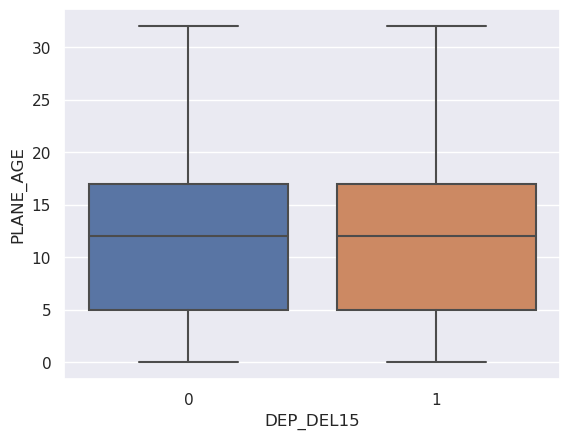

In [7]:
sns.boxplot(df, x='DEP_DEL15', y='PLANE_AGE')

In [5]:
df.columns

Index(['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'TAIL_NUM', 'DEST_AIRPORT_ID',
       'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY_NEW', 'DEP_DEL15',
       'DEP_TIME_BLK', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY_NEW',
       'ARR_TIME_BLK', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'DISTANCE',
       'DISTANCE_GROUP', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY',
       'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'SEGMENT_NUMBER',
       'CONCURRENT_FLIGHTS', 'NUMBER_OF_SEATS', 'CARRIER_NAME',
       'AIRPORT_FLIGHTS_MONTH', 'AIRLINE_FLIGHTS_MONTH',
       'AIRLINE_AIRPORT_FLIGHTS_MONTH', 'AVG_MONTHLY_PASS_AIRPORT',
       'AVG_MONTHLY_PASS_AIRLINE', 'FLT_ATTENDANTS_PER_PASS',
       'GROUND_SERV_PER_PASS', 'PLANE_AGE', 'DEPARTING_AIRPORT', 'LATITUDE',
       'LONGITUDE', 'PREVIOUS_AIRPORT', 'PRCP', 'SNOW', 'SNWD', 'TMAX',
       'AWND'],
      dtype='object')

<Axes: xlabel='DISTANCE', ylabel='DEP_DELAY_NEW'>

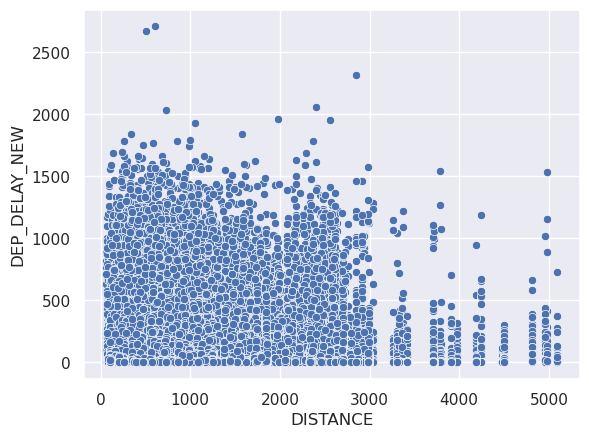

In [25]:
sns.scatterplot(df, x='DISTANCE', y='DEP_DELAY_NEW')